# 因子实验室分析流程复现 Notebook

本 Notebook 对应网页 `因子实验室` 的完整分析流程：
1. 选择因子（来源 / 股票池 / 时间范围）
2. 预处理（可选）
3. 选择收益口径
4. 执行分析并查看指标
5. 绘制图表（IC序列、IC累积和、分组收益、分组累积净值）
6. 保存分析结果

你只需要修改参数单元后，从上到下执行即可手动验证和复现网页分析结果。

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd().resolve().parent if Path.cwd().name == 'notebook' else Path.cwd().resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# 关键：切换到项目根目录，确保 get_local_data 的相对路径 ./daily_data 生效
os.chdir(ROOT)

from mylib.analysis_engine import AnalysisConfig, get_analysis_engine
from mylib.get_local_data import get_local_data

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', 200)
print('Project root =', ROOT)
print('CWD =', Path.cwd())

Project root = /data1/code_git/tick_data_analysis
CWD = /data1/code_git/tick_data_analysis


In [ ]:
# ===== 参数区（按需修改） =====
PARAMS = {
    # 因子配置
    'factor_name': 'pb',
    'source': 'fundamental',          # high_frequency / fundamental / technical
    'stock_pool': 'zz1000',

    # 日期范围
    'start_date': '20240201',
    'end_date': '20260210',

    # 预处理（None 表示不预处理）
    'preprocess_method': None,        # None / zscore / winsorize / normalize / rank / neutralize / mad / log
    'preprocess_params': {},          # 例如 {'lower_quantile':0.025,'upper_quantile':0.975}

    # 收益口径
    'returns_method': 'close2close_next',   # open2close / open2open_next / close2close_next / close2close_n
    'returns_n': 5,                   # close2close_n 时常用 3/5/10

    # 分层数
    'quantiles': 5,
}

PARAMS

{'factor_name': 'pe',
 'source': 'fundamental',
 'stock_pool': 'zz1000',
 'start_date': '20240201',
 'end_date': '20260210',
 'preprocess_method': None,
 'preprocess_params': {},
 'returns_method': 'close2close_next',
 'returns_n': 5,
 'quantiles': 5}

In [14]:
# 查看可用来源、因子、收益方法
engine = get_analysis_engine()

print('可用来源:', engine.factory.list_sources())
print('可用股票池:', engine.factory.list_stock_pools())
print('收益方法:')
for k, v in engine.calculator.list_methods().items():
    print(f'  - {k}: {v["name"]}')

factors = engine.factory.list_factors(PARAMS['source'])
print(f'\n来源 {PARAMS["source"]} 因子数量:', len(factors))
print('前20个因子:', factors[:20])

可用来源: ['high_frequency', 'fundamental', 'technical']
可用股票池: {'zz1000': ['中证1000成分股'], 'hs300': ['沪深300成分股'], 'zzxf': ['中证消费成分股']}
收益方法:
  - open2close: 次日开-次日收
  - open2open_next: 次日开-T+2开
  - close2close_next: 次日收-T+2收
  - close2close_n: 次日收-T+N收

来源 fundamental 因子数量: 9
前20个因子: ['pe', 'pb', 'ps', 'market_cap', 'roe', 'profit_growth', 'revenue_growth', 'debt_to_assets', 'current_ratio']


In [15]:
# 运行前检查：确认日线行情可读取（避免 run_analysis 时才报空数据）
sample_close = get_local_data(
    sec_list=None,
    start=PARAMS['start_date'],
    end=PARAMS['end_date'],
    filed='close',
    data_type='daily'
)

print('sample_close shape =', sample_close.shape)
if sample_close.empty:
    raise RuntimeError(
        f"日线数据为空，请检查日期范围或数据目录。cwd={Path.cwd()}，date={PARAMS['start_date']}~{PARAMS['end_date']}"
    )


[优化] 读取 3 年数据 (3 个合并文件, 0 个每日文件)
sample_close shape = (490, 5561)


In [16]:
# 构建配置并执行分析
config = AnalysisConfig(
    factor_name=PARAMS['factor_name'],
    source=PARAMS['source'],
    stock_pool=PARAMS['stock_pool'],
    start_date=PARAMS['start_date'],
    end_date=PARAMS['end_date'],
    preprocess_method=PARAMS['preprocess_method'],
    preprocess_params=PARAMS['preprocess_params'],
    returns_method=PARAMS['returns_method'],
    returns_n=PARAMS['returns_n'],
    quantiles=PARAMS['quantiles'],
)

result = engine.run_analysis(config)
print('分析完成时间:', result.created_at)

开始分析: pe (fundamental)
  [1/5] 加载因子数据...
       因子数据形状: (270, 941)
  [3/5] 计算收益率 (close2close_next)...
[优化] 读取 3 年数据 (3 个合并文件, 0 个每日文件)
[优化] 读取 3 年数据 (3 个合并文件, 0 个每日文件)
       收益率数据形状: (490, 941)
  [4/5] 对齐数据...
       对齐后形状: (270, 941)
       日期范围: 2025-01-02 00:00:00 ~ 2026-02-10 00:00:00
  [5/5] 计算分析指标...
       分析完成!
分析完成时间: 2026-02-14 20:12:57


In [17]:
# 核心指标
print('IC统计:', result.ic_stats)
print('多空统计:', result.long_short_stats)
print('换手率:', result.turnover_rate)

quantile_df = pd.DataFrame(result.quantile_returns)
quantile_df

IC统计: {'ic_mean': -0.001971065304610303, 'ic_std': 0.08280248138769032, 'ic_ir': -0.023804423147436346, 'ic_positive_ratio': 0.4626865671641791, 'ic_count': 268}
多空统计: {'total_return': 0.24911845354237583, 'mean_daily': 0.0008824794316702997, 'std_daily': 0.010211785937339428, 'sharpe': 1.371839046170337, 'win_rate': 0.5559701492537313, 'max_drawdown': -0.1253970089572953, 'count': 268}
换手率: 0.0009007265070379135


,quantile,mean,std,count,sharpe
0,1,0.001084,0.020994,38751,0.819897
1,2,0.001517,0.026799,38606,0.898778
2,3,0.001840,0.030653,38625,0.952781
3,4,0.001885,0.033880,38607,0.883429
4,5,0.001846,0.036226,38722,0.809017


<ipython-input-7-07330700bf5c>:21: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
<ipython-input-7-07330700bf5c>:21: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
<ipython-input-7-07330700bf5c>:21: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from current font.
  plt.tight_layout()
<ipython-input-7-07330700bf5c>:21: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from current font.
  plt.tight_layout()
<ipython-input-7-07330700bf5c>:21: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  plt.tight_layout()
<ipython-input-7-07330700bf5c>:21: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  plt.tight_layout()
<ipython-input-7-07330700bf5c>:21: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
<ipython-inpu

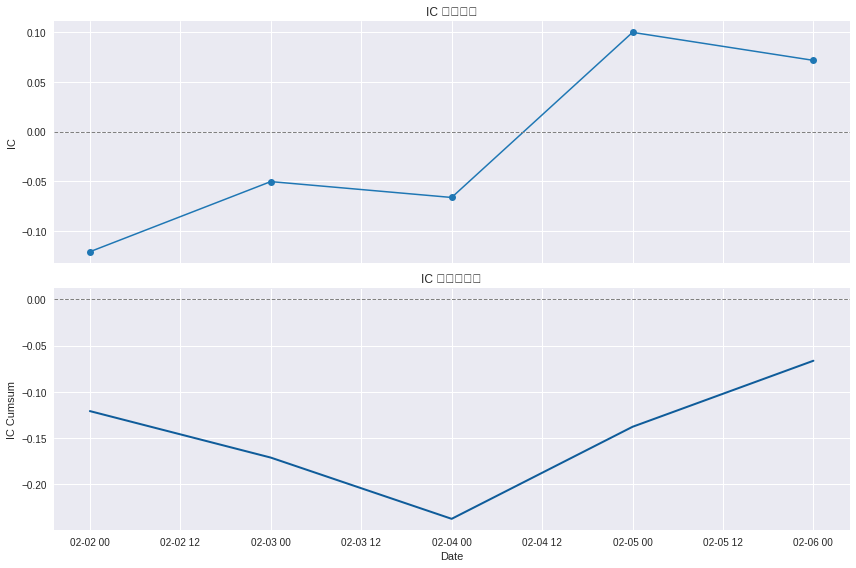

In [7]:
# 图1: IC 时间序列 + IC累积和
ic_df = pd.DataFrame(result.ic_series)
if not ic_df.empty:
    ic_df['date'] = pd.to_datetime(ic_df['date'])
    ic_df = ic_df.sort_values('date')
    ic_df['ic_cumsum'] = ic_df['ic'].cumsum()

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(ic_df['date'], ic_df['ic'], marker='o', lw=1.5, color='#1f77b4')
    axes[0].axhline(0, color='gray', ls='--', lw=1)
    axes[0].set_title('IC 时间序列')
    axes[0].set_ylabel('IC')

    axes[1].plot(ic_df['date'], ic_df['ic_cumsum'], lw=2, color='#0f5c9a')
    axes[1].axhline(0, color='gray', ls='--', lw=1)
    axes[1].set_title('IC 累积和走势')
    axes[1].set_ylabel('IC Cumsum')
    axes[1].set_xlabel('Date')

    plt.tight_layout()
    plt.show()
else:
    print('ic_series 为空，无法绘图')

/home/zxx/miniconda3/envs/quant/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zxx/miniconda3/envs/quant/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zxx/miniconda3/envs/quant/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zxx/miniconda3/envs/quant/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zxx/miniconda3/envs/quant/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK

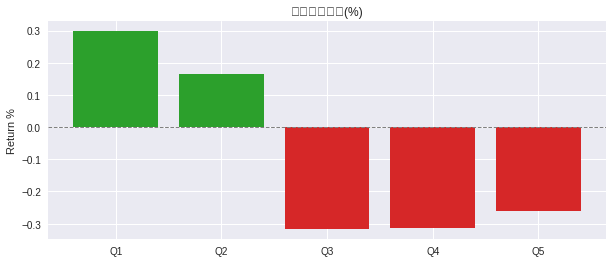

<ipython-input-8-a53af26cbffa>:32: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  plt.tight_layout()
<ipython-input-8-a53af26cbffa>:32: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  plt.tight_layout()
<ipython-input-8-a53af26cbffa>:32: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
<ipython-input-8-a53af26cbffa>:32: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  plt.tight_layout()
<ipython-input-8-a53af26cbffa>:32: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  plt.tight_layout()
<ipython-input-8-a53af26cbffa>:32: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  plt.tight_layout()
<ipython-input-8-a53af26cbffa>:32: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from current font.
  plt.tight_layout()
<ipython-inpu

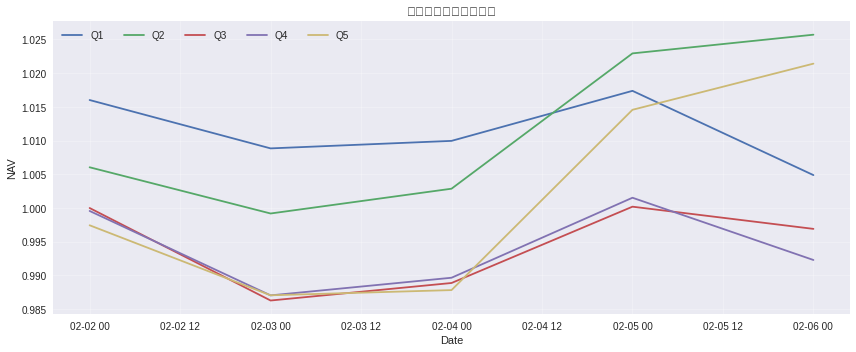

In [8]:
# 图2: 分层平均收益柱状图 + 分组累积净值走势
if not quantile_df.empty:
    qx = quantile_df['quantile'].astype(str).radd('Q')
    qy = quantile_df['mean'] * 100

    plt.figure(figsize=(10, 4))
    colors = ['#2ca02c' if x >= 0 else '#d62728' for x in qy]
    plt.bar(qx, qy, color=colors)
    plt.axhline(0, color='gray', ls='--', lw=1)
    plt.title('分层平均收益(%)')
    plt.ylabel('Return %')
    plt.show()

qd = pd.DataFrame(result.charts_data.get('quantile_daily', []))
if not qd.empty:
    qd['date'] = pd.to_datetime(qd['date'])
    qd = qd.sort_values('date')
    q_cols = [c for c in qd.columns if c.startswith('Q')]

    nav = pd.DataFrame({'date': qd['date']})
    for c in q_cols:
        nav[c] = (1 + qd[c].fillna(0)).cumprod()

    plt.figure(figsize=(12, 5))
    for c in q_cols:
        plt.plot(nav['date'], nav[c], label=c, lw=1.8)
    plt.title('不同分组累积净值走势')
    plt.xlabel('Date')
    plt.ylabel('NAV')
    plt.legend(ncol=min(5, len(q_cols)))
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    print('quantile_daily 为空，无法绘制分组净值')

In [9]:
# 保存分析结果（与网页“保存结果”一致）
save_path = engine.save_result(result)
print('结果保存路径:', save_path)

结果保存路径: /data1/code_git/tick_data_analysis/factor/analysis/20260214_pe_raw


## 可选：用 Flask API 复现网页请求

如果你更想严格复现前端调用，可在启动 `python factor_dashboard/app.py` 后，用下述方式请求：

```python
import requests
payload = {
    'factor': PARAMS['factor_name'],
    'source': PARAMS['source'],
    'stock_pool': PARAMS['stock_pool'],
    'start_date': PARAMS['start_date'],
    'end_date': PARAMS['end_date'],
    'preprocess': {
        'method': PARAMS['preprocess_method'],
        'params': PARAMS['preprocess_params'],
    } if PARAMS['preprocess_method'] else None,
    'config': {
        'returns_type': PARAMS['returns_method'],
        'returns_n': PARAMS['returns_n'],
        'quantiles': PARAMS['quantiles'],
    }
}
resp = requests.post('http://127.0.0.1:9999/api/factor/analyze', json=payload, timeout=120)
resp.json()
```